## Sequence to Sequence: Encoder & Decoder Architecture

In [76]:
import copy
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, \
TensorDataset
from data_generation.square_sequence import generate_sequences
from stepbystep.v4 import StepByStep

In [77]:
#Creating data points (of squares) and their direction
points, directions=generate_sequences(n=128, seed=13)

## Encoder
" The encoder's goal is to generate a representation of the $\textbf{source sequence}$, that is, to encode it

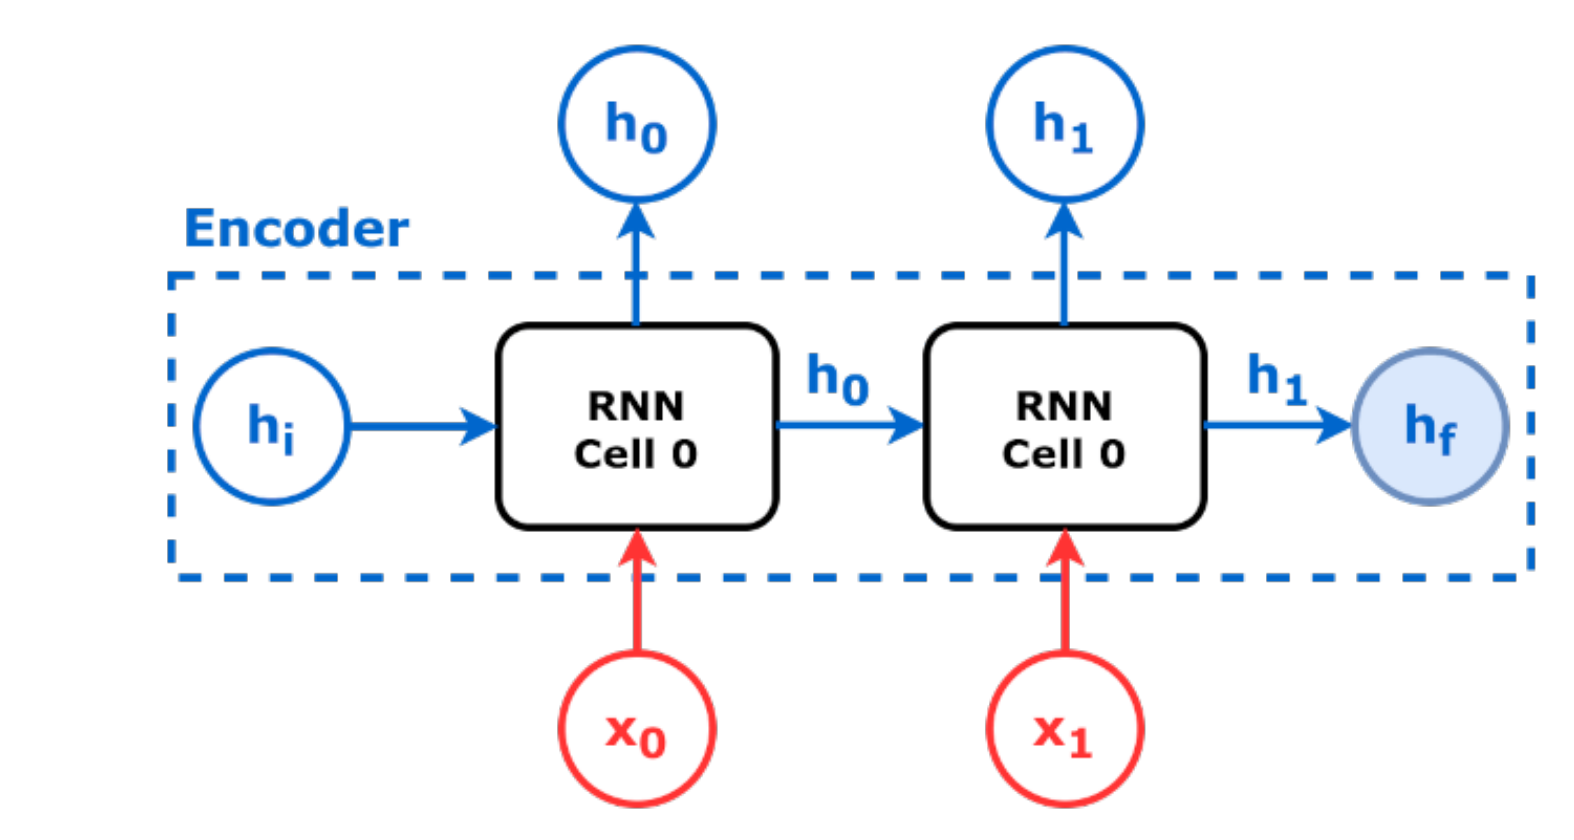

In [78]:
class Encoder(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super().__init__()
        self.hidden_dim=hidden_dim
        self.n_features=n_features
        self.hidden=None
        self.basic_rnn=nn.GRU(
        self.n_features,
        self.hidden_dim,
        batch_first=True)
    
    def forward(self, X):
        rnn_out, self.hidden=self.basic_rnn(X)
        
        return rnn_out
        

In [79]:
#ejemplo de un cuadrado perfecto
full_seq=(torch.tensor([[-1,-1],[-1,1],[1,1],[1,-1]])).float().view(1,4,2)
source_seq=full_seq[:,:2,:]
target_seq=full_seq[:,2:,:]

In [80]:
source_seq, source_seq.size()

(tensor([[[-1., -1.],
          [-1.,  1.]]]),
 torch.Size([1, 2, 2]))

In [81]:
torch.manual_seed(21)
encoder=Encoder(n_features=2, hidden_dim=2)
hidden_seq=encoder(source_seq) #output N, L F
hidden_seq

tensor([[[ 0.0832, -0.0356],
         [ 0.3105, -0.5263]]], grad_fn=<TransposeBackward1>)

In [82]:
#The last hidden state is the one that encode in a better way the whole sequence
final_state=hidden_seq[:,-1:,:]
final_state

tensor([[[ 0.3105, -0.5263]]], grad_fn=<SliceBackward>)

## Decoder
The decoder's goal is to generate the target sequence from an initial representation, that is, to decode it

In order to decode the hidden state of into a sequence, the decoder needs a recurent layer as well
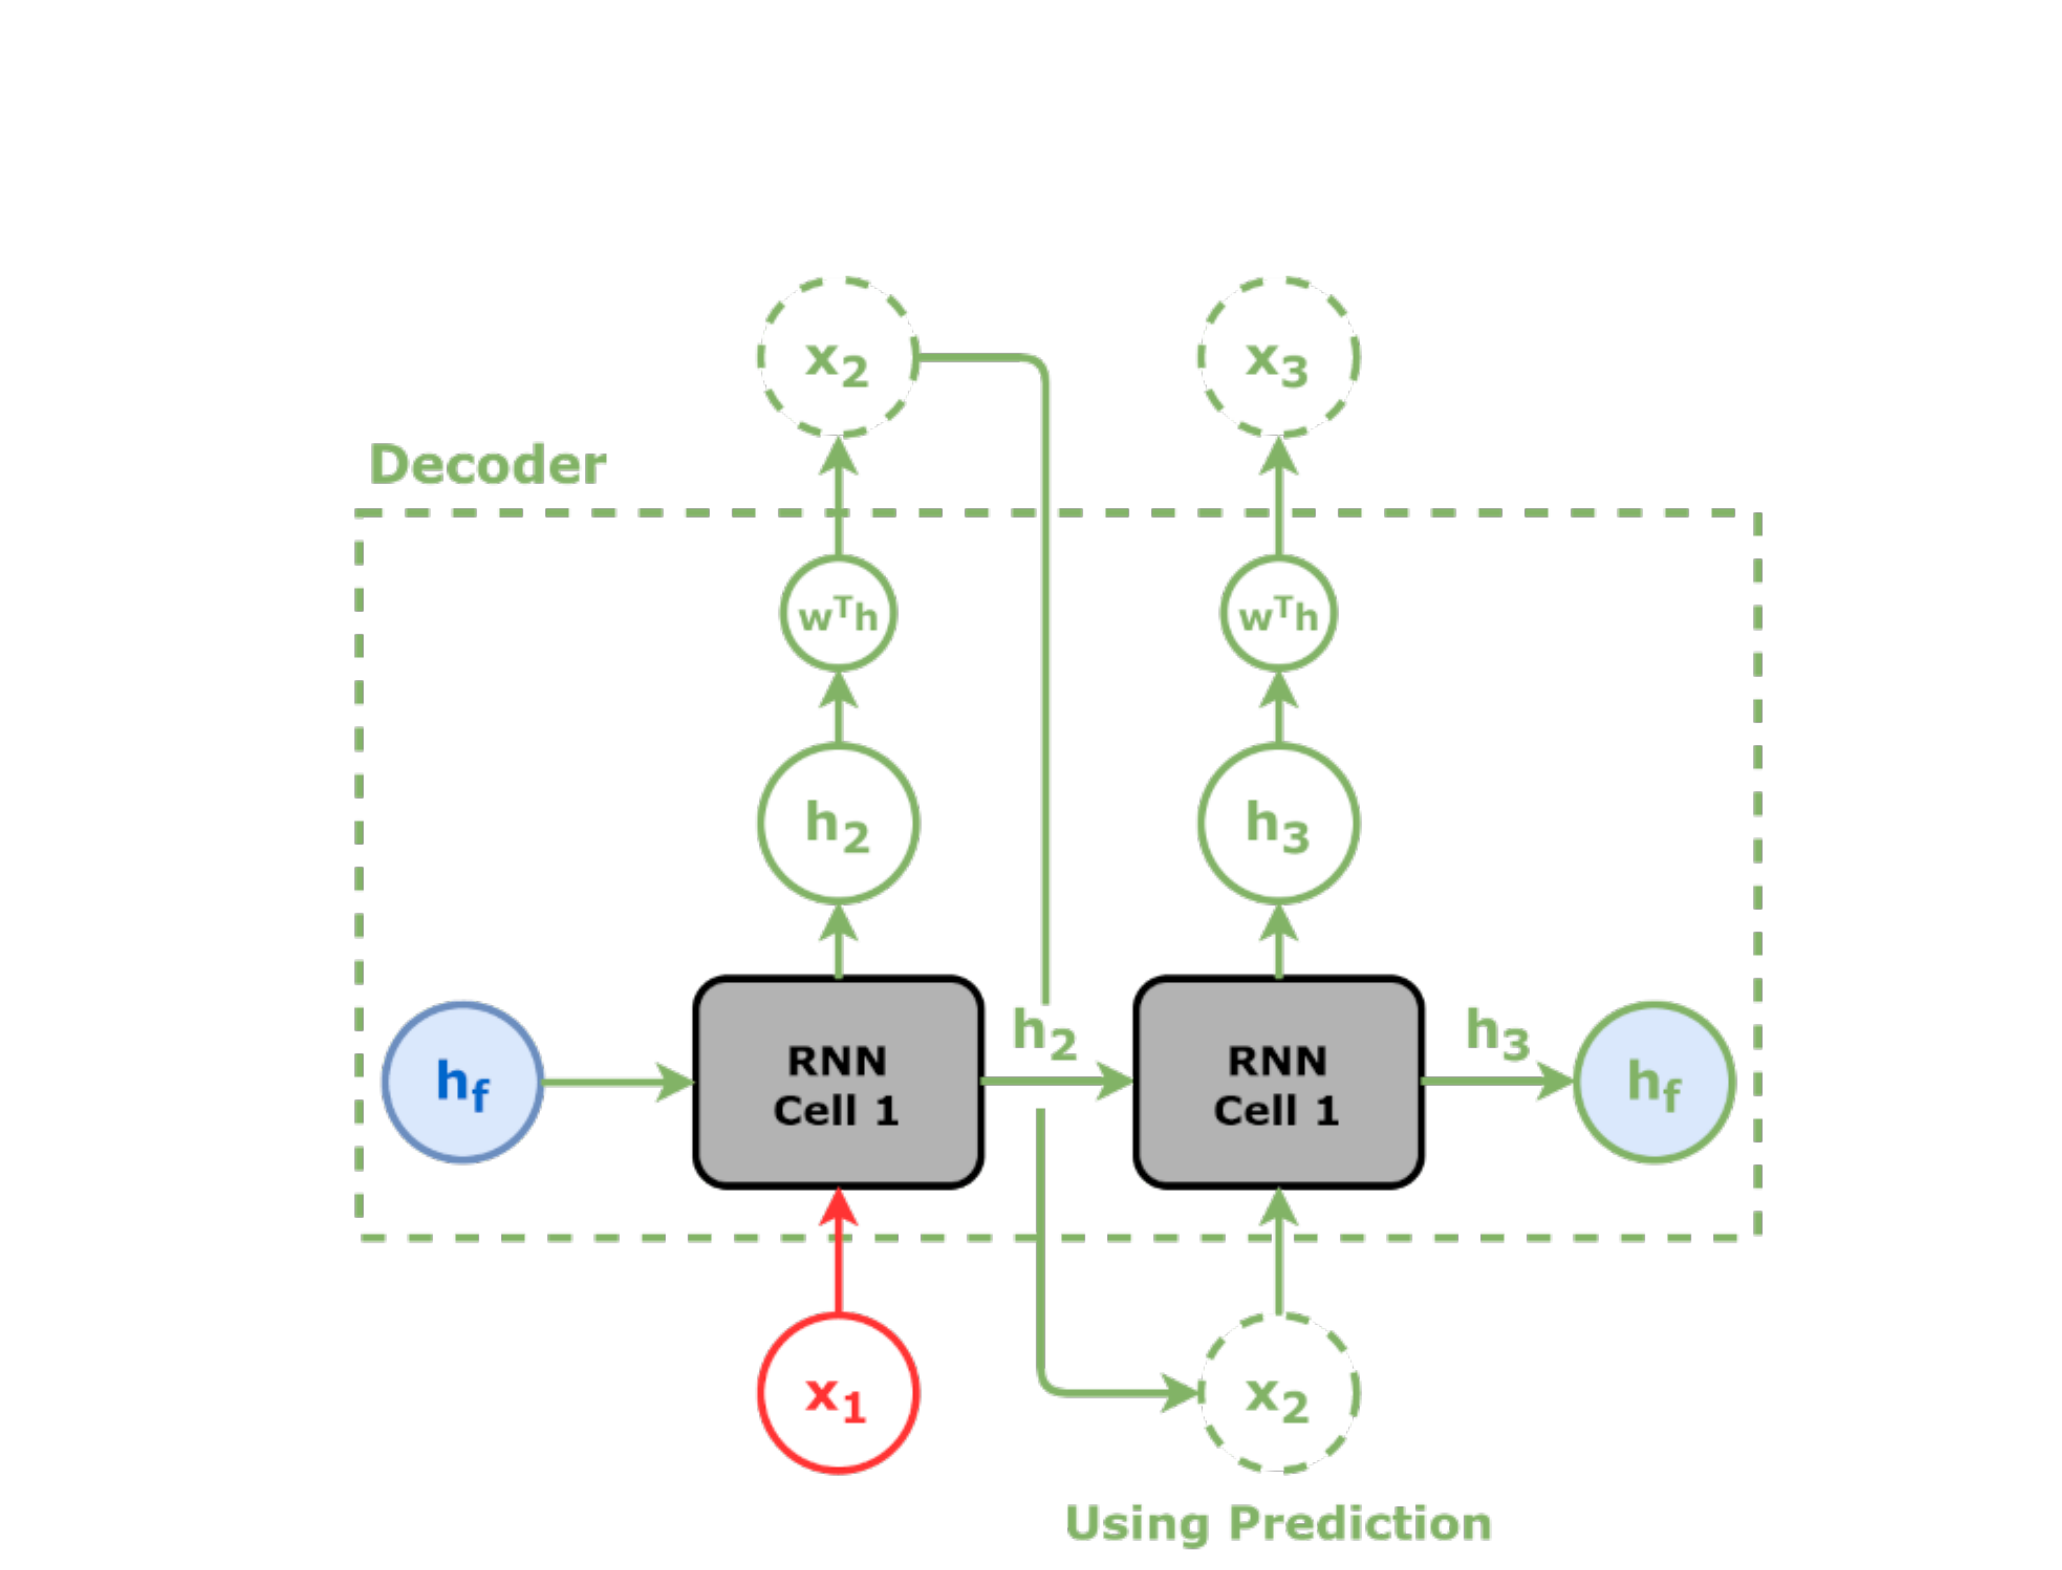

In [83]:
class Decoder(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super().__init__()
        self.n_features=n_features
        self.hidden_dim=hidden_dim
        self.basic_rnn=nn.GRU(self.n_features, 
                             self.hidden_dim,
                             batch_first=True)
        self.regression=nn.Linear(self.hidden_dim, n_features)
    
    def init_hidden(self, hidden_seq):
        #we only need the final state
        hidden_final=hidden_seq[:,-1:,:] #N,1,H
        #but it is needed to make this sequence-first
        self.hidden=hidden_final.permute(1,0,2) #1,N,H
        
    def forward(self, X):
        # X is N, 1, F
        batch_first_output, self.hidden=self.basic_rnn(X, self.hidden)
        
        last_output=batch_first_output[:,-1:,:]
        out=self.regression(last_output)
        
        #N,1,F
        return out.view(-1,1,self.n_features)

In [84]:
hidden_seq

tensor([[[ 0.0832, -0.0356],
         [ 0.3105, -0.5263]]], grad_fn=<TransposeBackward1>)

In [85]:
torch.manual_seed(21)
decoder=Decoder(n_features=2, hidden_dim=2)

#initial hidden state will be encoder's final hidden state
decoder.init_hidden(hidden_seq)
#initial data point is the last element of source sequence
inputs=source_seq[:,-1:,:]

target_len=2
for i in range(target_len):
    print(f"Hidden: {decoder.hidden}")
    out=decoder(inputs) #predicts coordinates
    print(f"Outputs: {out}\n")
    inputs=out

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward>)
Outputs: tensor([[[-0.2339,  0.4702]]], grad_fn=<ViewBackward>)

Hidden: tensor([[[ 0.3913, -0.6853]]], grad_fn=<StackBackward>)
Outputs: tensor([[[-0.0226,  0.4628]]], grad_fn=<ViewBackward>)



## Teacher Forcing

In the last cell, the decoder was feed with the output prediction of itself; then, an untrained model will make really mad predictions, and this predictions will still be used as inputs for subsequent steps.

### Teacher forcing
But we can use actual target instead

In [86]:
#as before, initial hidden state will be encoder's final hidden state
decoder.init_hidden(hidden_seq)
#initial datapoint is the last element of source sequence
inputs=source_seq[:,-1:]

target_len=2
for i in range(target_len):
    print(f"Hidden: {decoder.hidden}")
    out=decoder(inputs) #predicts coordinates
    print(f"Outputs: {out}\n")
    inputs=target_seq[:,i:i+1]
    

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward>)
Outputs: tensor([[[-0.2339,  0.4702]]], grad_fn=<ViewBackward>)

Hidden: tensor([[[ 0.3913, -0.6853]]], grad_fn=<StackBackward>)
Outputs: tensor([[[0.2265, 0.4529]]], grad_fn=<ViewBackward>)



In terms of training time this is amazing, but at testing time when the target sequence is unkown this will not help us.

That's why it is customary to alternate over teacher forcing and use as input decoder's own predictions:

In [87]:
decoder.init_hidden(hidden_seq)
inputs=source_seq[:,-1:,:]

teacher_forcing_prob=.5
target_len=2
for i in range(target_len):
    print(f"Hidden: {decoder.hidden}")
    out=decoder(inputs)
    print(f"outout: {out}\n")
    #if teacher forcing
    if torch.rand(1) <= teacher_forcing_prob:
        #takes tehe actual element
        inputs=target_seq[:,i:i+1,:]
    else:
        inputs=out

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward>)
outout: tensor([[[-0.2339,  0.4702]]], grad_fn=<ViewBackward>)

Hidden: tensor([[[ 0.3913, -0.6853]]], grad_fn=<StackBackward>)
outout: tensor([[[-0.0226,  0.4628]]], grad_fn=<ViewBackward>)



# Encoder-Decoder (with recurrent units)

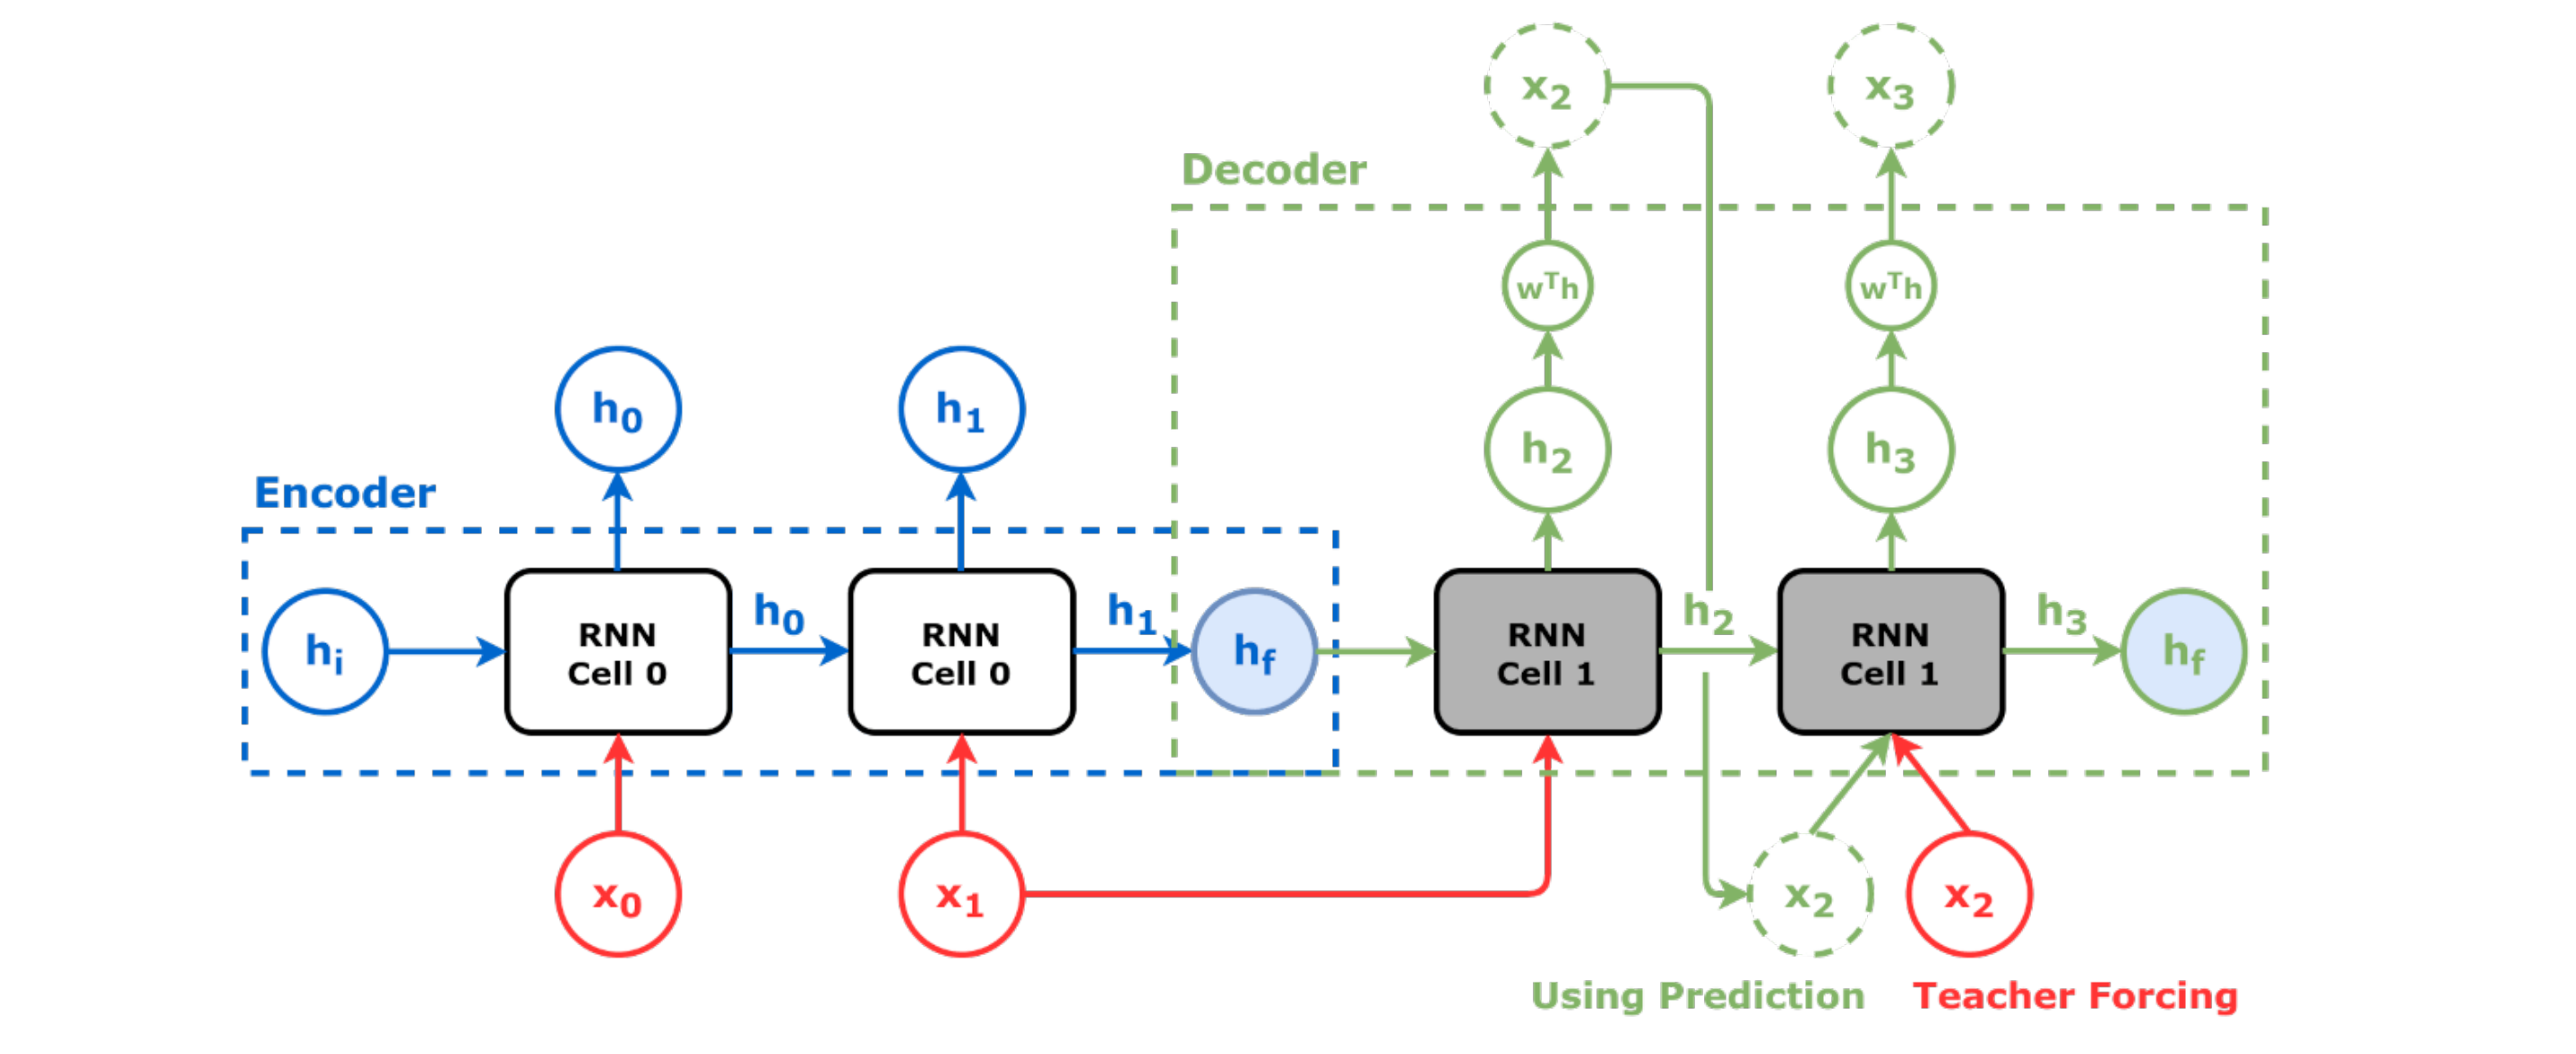

In [88]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, input_len, target_len,
                teacher_forcing_prob=.5):
        super().__init__()
        self.encoder=encoder
        self.decoder=decoder
        self.input_len=input_len
        self.target_len=target_len
        self.teacher_forcing_prob=teacher_forcing_prob
        self.outputs=None
        
    def init_outputs(self,batch_size):
        device=next(self.parameters()).device
        #N,L(target), F
        self.outputs=torch.zeros(batch_size, 
                                self.target_len,
                                self.encoder.n_features).to(device)
    def store_output(self, i, out):
        self.outputs[:,i:i+1,:]=out
    
    def forward(self, X):
        #splits the data in source and target sequences
        #the target se will be emptu in testing mode
        #N,L,F
        source_seq=X[:, :self.input_len, :]
        target_seq=X[:, self.input_len:, :]
        #zeros matrix is created in the line below
        self.init_outputs(X.shape[0])
        
        #Encoder expected, N,L,F
        hidden_seq=self.encoder(source_seq)
        self.decoder.init_hidden(hidden_seq)
        
        #the last input of the encoder is also
        #the fist input of the decoder
        dec_inputs=source_seq[:, -1: ,:]
        
        for i in range(self.target_len):
            #Output of decoder is N,1,F
            out=self.decoder(dec_inputs)
            self.store_output(i, out)
            
            prob=self.teacher_forcing_prob
            #In eval/test the target sequence is 
            #Unknown, so we cannot use teacher forcing
            if not self.training:
                prob=0
            #if it is training time
            if torch.rand(1)<= prob:
                #takes the actua element
                dec_inputs=target_seq[:,i:i+1, :]
            else:
                dec_inputs=out
                
            return self.outputs
        
        

In [89]:
#Create an instance of the above model
encdec=EncoderDecoder(encoder, decoder,
                     input_len=2, target_len=2,
                     teacher_forcing_prob=.5)

In [90]:
# In training mode, the model expects the full sequence, so it can randomly use teacher
#forcing
encdec.train()
print(encdec(full_seq))
# while in eval/test mode, it only need the source sequence as input
encdec.eval()
encdec(source_seq)

tensor([[[-0.2339,  0.4702],
         [ 0.0000,  0.0000]]], grad_fn=<CopySlices>)


tensor([[[-0.2339,  0.4702],
         [ 0.0000,  0.0000]]], grad_fn=<CopySlices>)

In [91]:
# Data preparation (TRAIN)
points, directions=generate_sequences()
full_train=torch.as_tensor(points).float()
target_train=full_train[:,2:,:]

In [92]:
#for test set, we only need the source sequence as features (X) and the target 
#sequence as labels (y)
test_points, test_directions=generate_sequences(seed=19)
full_test=torch.as_tensor(points).float()
source_test=full_test[:,:2,:]
target_test=full_test[:,2:,:]


In [93]:
#create TensorDatasets
train_data = TensorDataset(full_train, target_train)
test_data = TensorDataset(source_test, target_test)

In [94]:
#create dataloader
generator = torch.Generator()
train_loader = DataLoader(train_data, batch_size=16,
shuffle=True, generator=generator)
test_loader = DataLoader(test_data, batch_size=16)

In [95]:
#Model configuration
torch.manual_seed(23)
encoder = Encoder(n_features=2, hidden_dim=2)
decoder = Decoder(n_features=2, hidden_dim=2)
model = EncoderDecoder(encoder, decoder,
input_len=2, target_len=2,
teacher_forcing_prob=0.5)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [96]:
#model training
sbs_seq = StepByStep(model, loss, optimizer)
sbs_seq.set_loaders(train_loader, test_loader)
sbs_seq.train(100)

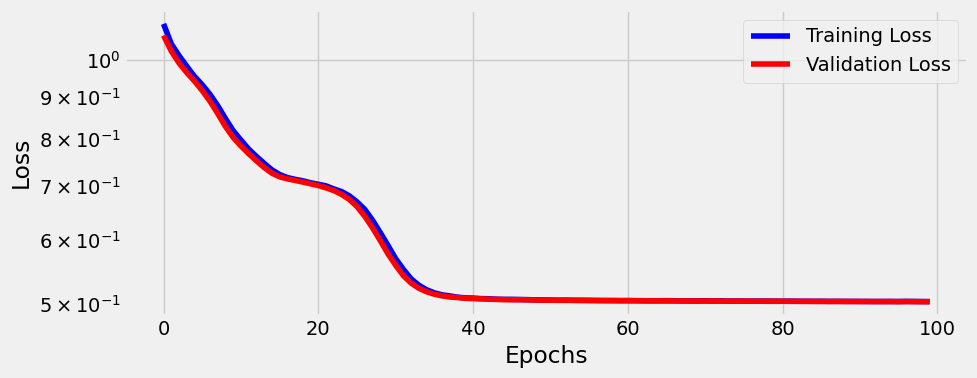

In [97]:
fig = sbs_seq.plot_losses()
fig

## Attention Mechanism

In [98]:
# Demonstrative example of a Attention Mechanism before compute a "real" one

In [99]:
full_seq=(torch.tensor([[-1,-1], [-1,1],[1,1],[1,-1]]).float().view(1,4,2))
source_seq=full_seq[:,:2, :]
target_seq=full_seq[:,2:,:]

#the source sequence is the input of the encoder, and the hidden states it outputs
#are going to be both values $\textbf{V}$ and keys $\textbf{K}$

In [100]:
torch.manual_seed(21)
encoder=Encoder(n_features=2, hidden_dim=2)
hidden_seq=encoder(source_seq)

values=hidden_seq
values


tensor([[[ 0.0832, -0.0356],
         [ 0.3105, -0.5263]]], grad_fn=<TransposeBackward1>)

In [101]:
keys=hidden_seq
keys

tensor([[[ 0.0832, -0.0356],
         [ 0.3105, -0.5263]]], grad_fn=<TransposeBackward1>)

In [102]:
torch.manual_seed(21)
decoder=Decoder(n_features=2, hidden_dim=2)
decoder.init_hidden(hidden_seq)

inputs=source_seq[:,-1:,:]
out=decoder(inputs)

In [103]:
decoder.hidden

tensor([[[ 0.3913, -0.6853]]], grad_fn=<StackBackward>)

In [104]:
query=decoder.hidden.permute(1,0,2) #back to N, 1, H

Having Keys and Querys, it is possible to pretend to compute $\textbf{attention scores} (alphas)$

In [105]:
def calc_alphas(ks, q):
    N,L,H=ks.size()
    alphas=torch.ones(N,1,L).float()*1/L
    return alphas

alphas=calc_alphas(keys, query)
alphas

tensor([[[0.5000, 0.5000]]])

Alphas need to be the right shape, that is (N, 1, L), so that, when multiplied by values with shape (N, L, H) it will result in a weighted sum of the alignment vectors with shape (N, 1, H):
$
\begin{equation}
(N, 1, L) \times(N, L, H) = (N,1,H)
\end{equation}
$

In [106]:
context_vector=torch.bmm(alphas, values)
context_vector

tensor([[[ 0.1968, -0.2809]]], grad_fn=<BmmBackward0>)

In [107]:
#Once we have the context_vector (even if this one it is not a context vector in strict sense)
#we concatenet context vector with query (decoder hidden state)
concatenated=torch.cat([context_vector, query],axis=2)
concatenated

tensor([[[ 0.1968, -0.2809,  0.3913, -0.6853]]], grad_fn=<CatBackward>)

the next diagram illustrates the whole mechanism
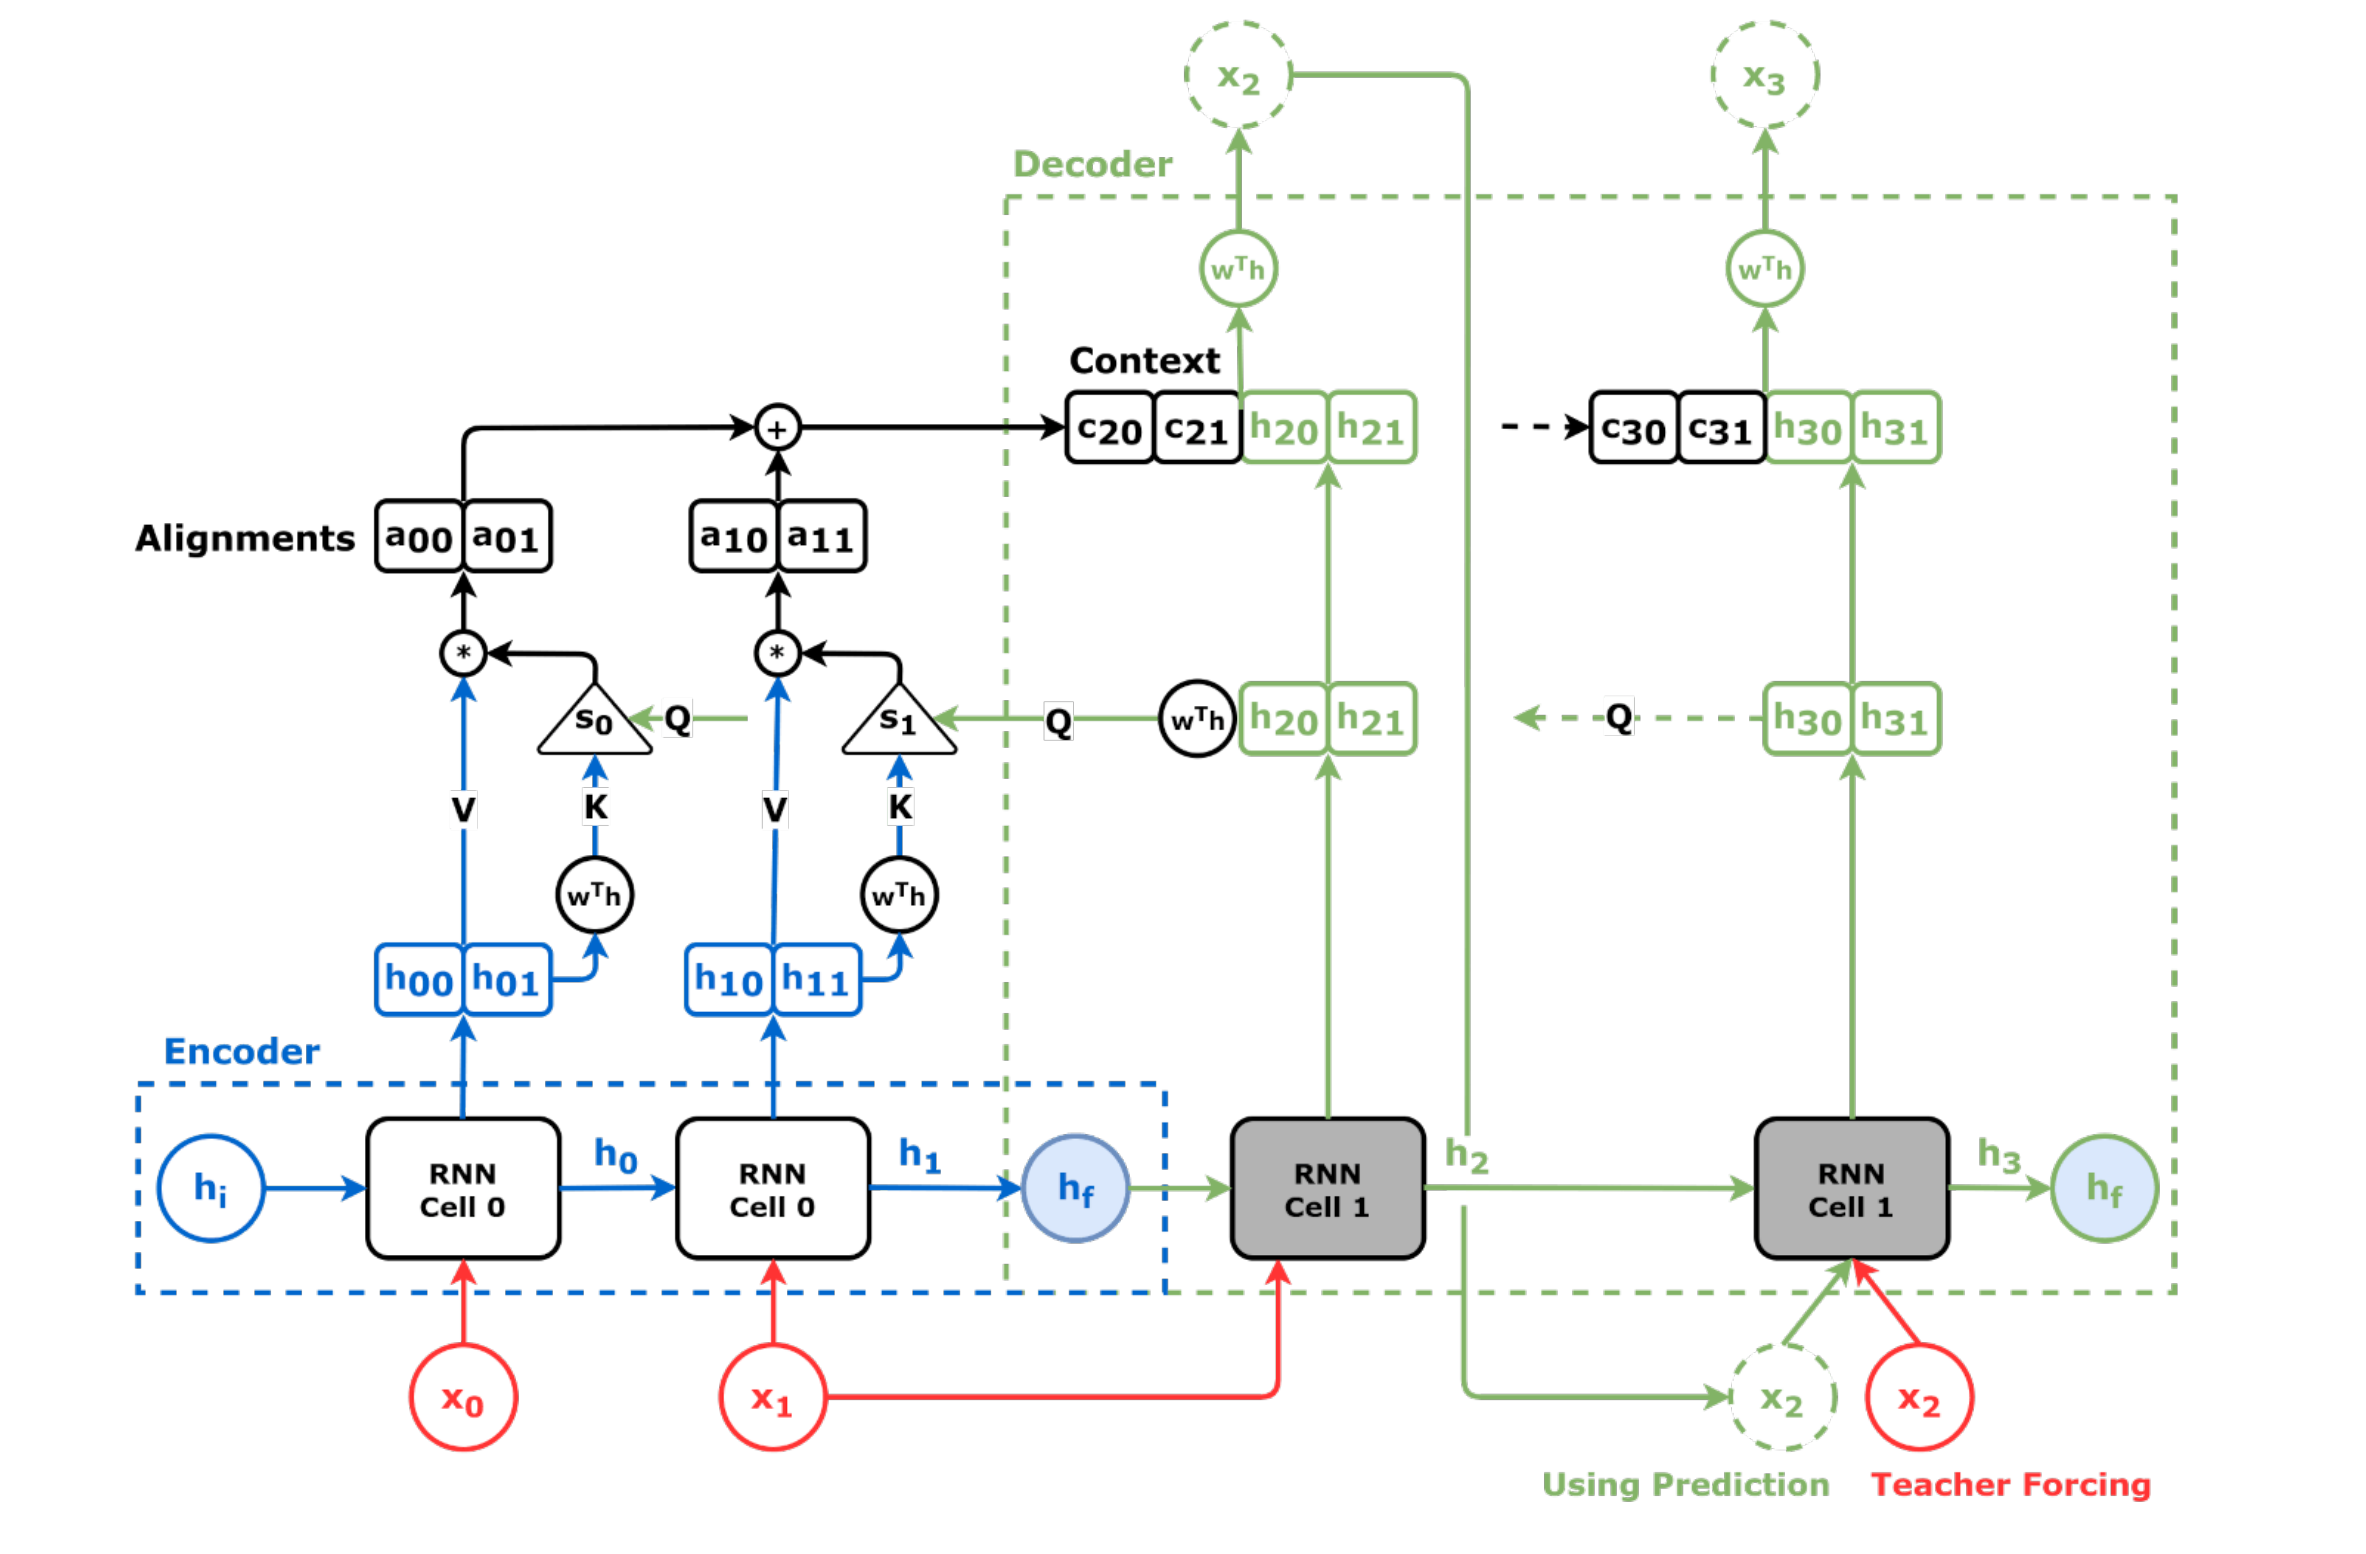

## Scoring method
The scoring method determine if two vectors are $\textbf{similar}$. One way to achive that is calculating a scale norm of the cosine similarity between Q's and K's.




In [108]:
query

tensor([[[ 0.3913, -0.6853]]], grad_fn=<PermuteBackward>)

In [109]:
keys

tensor([[[ 0.0832, -0.0356],
         [ 0.3105, -0.5263]]], grad_fn=<TransposeBackward1>)

In [110]:
products=torch.bmm(query, keys.permute(0,2,1))
products

tensor([[[0.0569, 0.4821]]], grad_fn=<BmmBackward0>)

In [111]:
#but they are not attention scores, since they do NOT add up to one
#they arealignment scores.

In [112]:
#TO create attention scores
alphas=F.softmax(products, dim=-1)
alphas

tensor([[[0.3953, 0.6047]]], grad_fn=<SoftmaxBackward>)

In [113]:
#update calc_function
def calc_alphas(ks, q):
    dims=q.size(-1)
    products=torch.bmm(q, ks.permute(0, 2,1))
    scaled_products=products/np.sqrt(dims)
    alphas=F.softmax(scaled_products, dim=-1)
    return alphas

In [114]:
alphas=calc_alphas(keys, query)
context_vector=torch.bmm(alphas, values)
context_vector

tensor([[[ 0.2138, -0.3175]]], grad_fn=<BmmBackward0>)

## Attention Mechanism

In [162]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, input_dim=None, proj_values=False):
        super().__init__()
        self.d_k=hidden_dim
        self.input_dim=hidden_dim if input_dim is None else input_dim
        self.proj_values=proj_values
        #Affine transformations for q, k, and v
        self.linear_query=nn.Linear(self.input_dim, hidden_dim)
        self.linear_keys=nn.Linear(self.input_dim, hidden_dim)
        self.linear_value=nn.Linear(self.input_dim, hidden_dim)
        self.alphas=None
    
    def init_keys(self, keys):
        self.keys=keys
        self.proj_keys=self.linear_keys(self.keys)
        self.values=self.linear_value(self.keys) if self.proj_values else self.keys
        
    def score_function(self, query):
        proj_query=self.linear_query(query)
        #scaled dot products
        #N, 1, H x N, H, L ---> N,1,L
        dot_products=torch.bmm(proj_query, self.proj_keys.permute(0,2,1))
        scores=dot_products/np.sqrt(self.d_k)
        
        return scores
    
    def forward(self, query, mask=None):
        #query is batch-first
        scores=self.score_function(query)#N, 1, L
        if mask is not None:
            scores=scores.masked_fill(mask==0, -1e9)
        alphas = F.softmax(scores, dim=-1) # N, 1, L
        #las alphas no se van a entrenar o qué?
        self.alphas = alphas.detach()
        
        #N, 1, L x N, L, H --> N, 1 , H
        context = torch.bmm(alphas, self.values)
        return context
        

# Source Mask 

In [163]:
source_seq = torch.tensor([[[-1., 1.], [0., 0.]]])
source_seq1=torch.tensor([[[-1.,1.,1.,1.],[1.,1.,1.,2.],[0.,0.,0.,0.],[0.,0.,0.,0.]]])
# pretend there's an encoder here...
keys = torch.tensor([[[-.38, .44], [.85, -.05]]])
query = torch.tensor([[[-1., 1.]]])

In [164]:
source_mask = (source_seq != 0).all(axis=2).unsqueeze(1)
print(source_mask)
source_mask1=(source_seq1 !=0).all(axis=2).unsqueeze(1)
source_mask1

tensor([[[ True, False]]])


tensor([[[ True,  True, False, False]]])

In [165]:
mask=source_mask1.ge(.0001)
mask

tensor([[[ True,  True, False, False]]])

In [166]:
torch.manual_seed(11)
attnh = Attention(2)
attnh.init_keys(keys)
context = attnh(query, mask=source_mask)
attnh.alphas

tensor([[[1., 0.]]])

## Decoder
small adjusments to the decoder function

In [167]:
class DecoderAttn(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super().__init__()
        self.hidden_dim=hidden_dim
        self.n_features=n_features
        self.hidden=None
        self.basic_rnn=nn.GRU(self.n_features, 
                             self.hidden_dim, 
                             batch_first=True)
        self.attn=Attention(self.hidden_dim)
        #algo que se debe cambiar, claro
        self.regression=nn.Linear(2*self.hidden_dim,
                                 self.n_features)
    
    def init_hidden(self, hidden_seq):
        self.attn.init_keys(hidden_seq)
        hidden_final=hidden_seq[:,-1:,:]
        self.hidden=hidden_final.permute(1,0,2)
        
    def forward(self, X, mask=None):
        #X is in N, 1, F
        batch_first_output, self.hidden=self.basic_rnn(X, self.hidden)
        query=batch_first_output[:,-1:,:]
        #attention
        context=self.attn(query, mask=mask)
        concatenated=torch.cat([context, query], axis=-1)
        out=self.regression(concatenated)
        
        #N, 1, F
        return out.view(-1,1, self.n_features)
        
        

In [168]:
full_seq = (torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4, 2))
source_seq = full_seq[:, :2]
target_seq = full_seq[:, 2:]

In [169]:
torch.manual_seed(21)
encoder = Encoder(n_features=2, hidden_dim=2)
decoder_attn = DecoderAttn(n_features=2, hidden_dim=2)

In [170]:
# Generates hidden states (keys and values)
hidden_seq = encoder(source_seq)
decoder_attn.init_hidden(hidden_seq)

In [171]:
# Target sequence generation
inputs = source_seq[:, -1:]
target_len = 2
for i in range(target_len):
    out = decoder_attn(inputs)
    print(f'Output: {out}')
    inputs = out

Output: tensor([[[-0.3555, -0.1220]]], grad_fn=<ViewBackward>)
Output: tensor([[[-0.2641, -0.2521]]], grad_fn=<ViewBackward>)


## Encoder - Decoder PLUS Attention

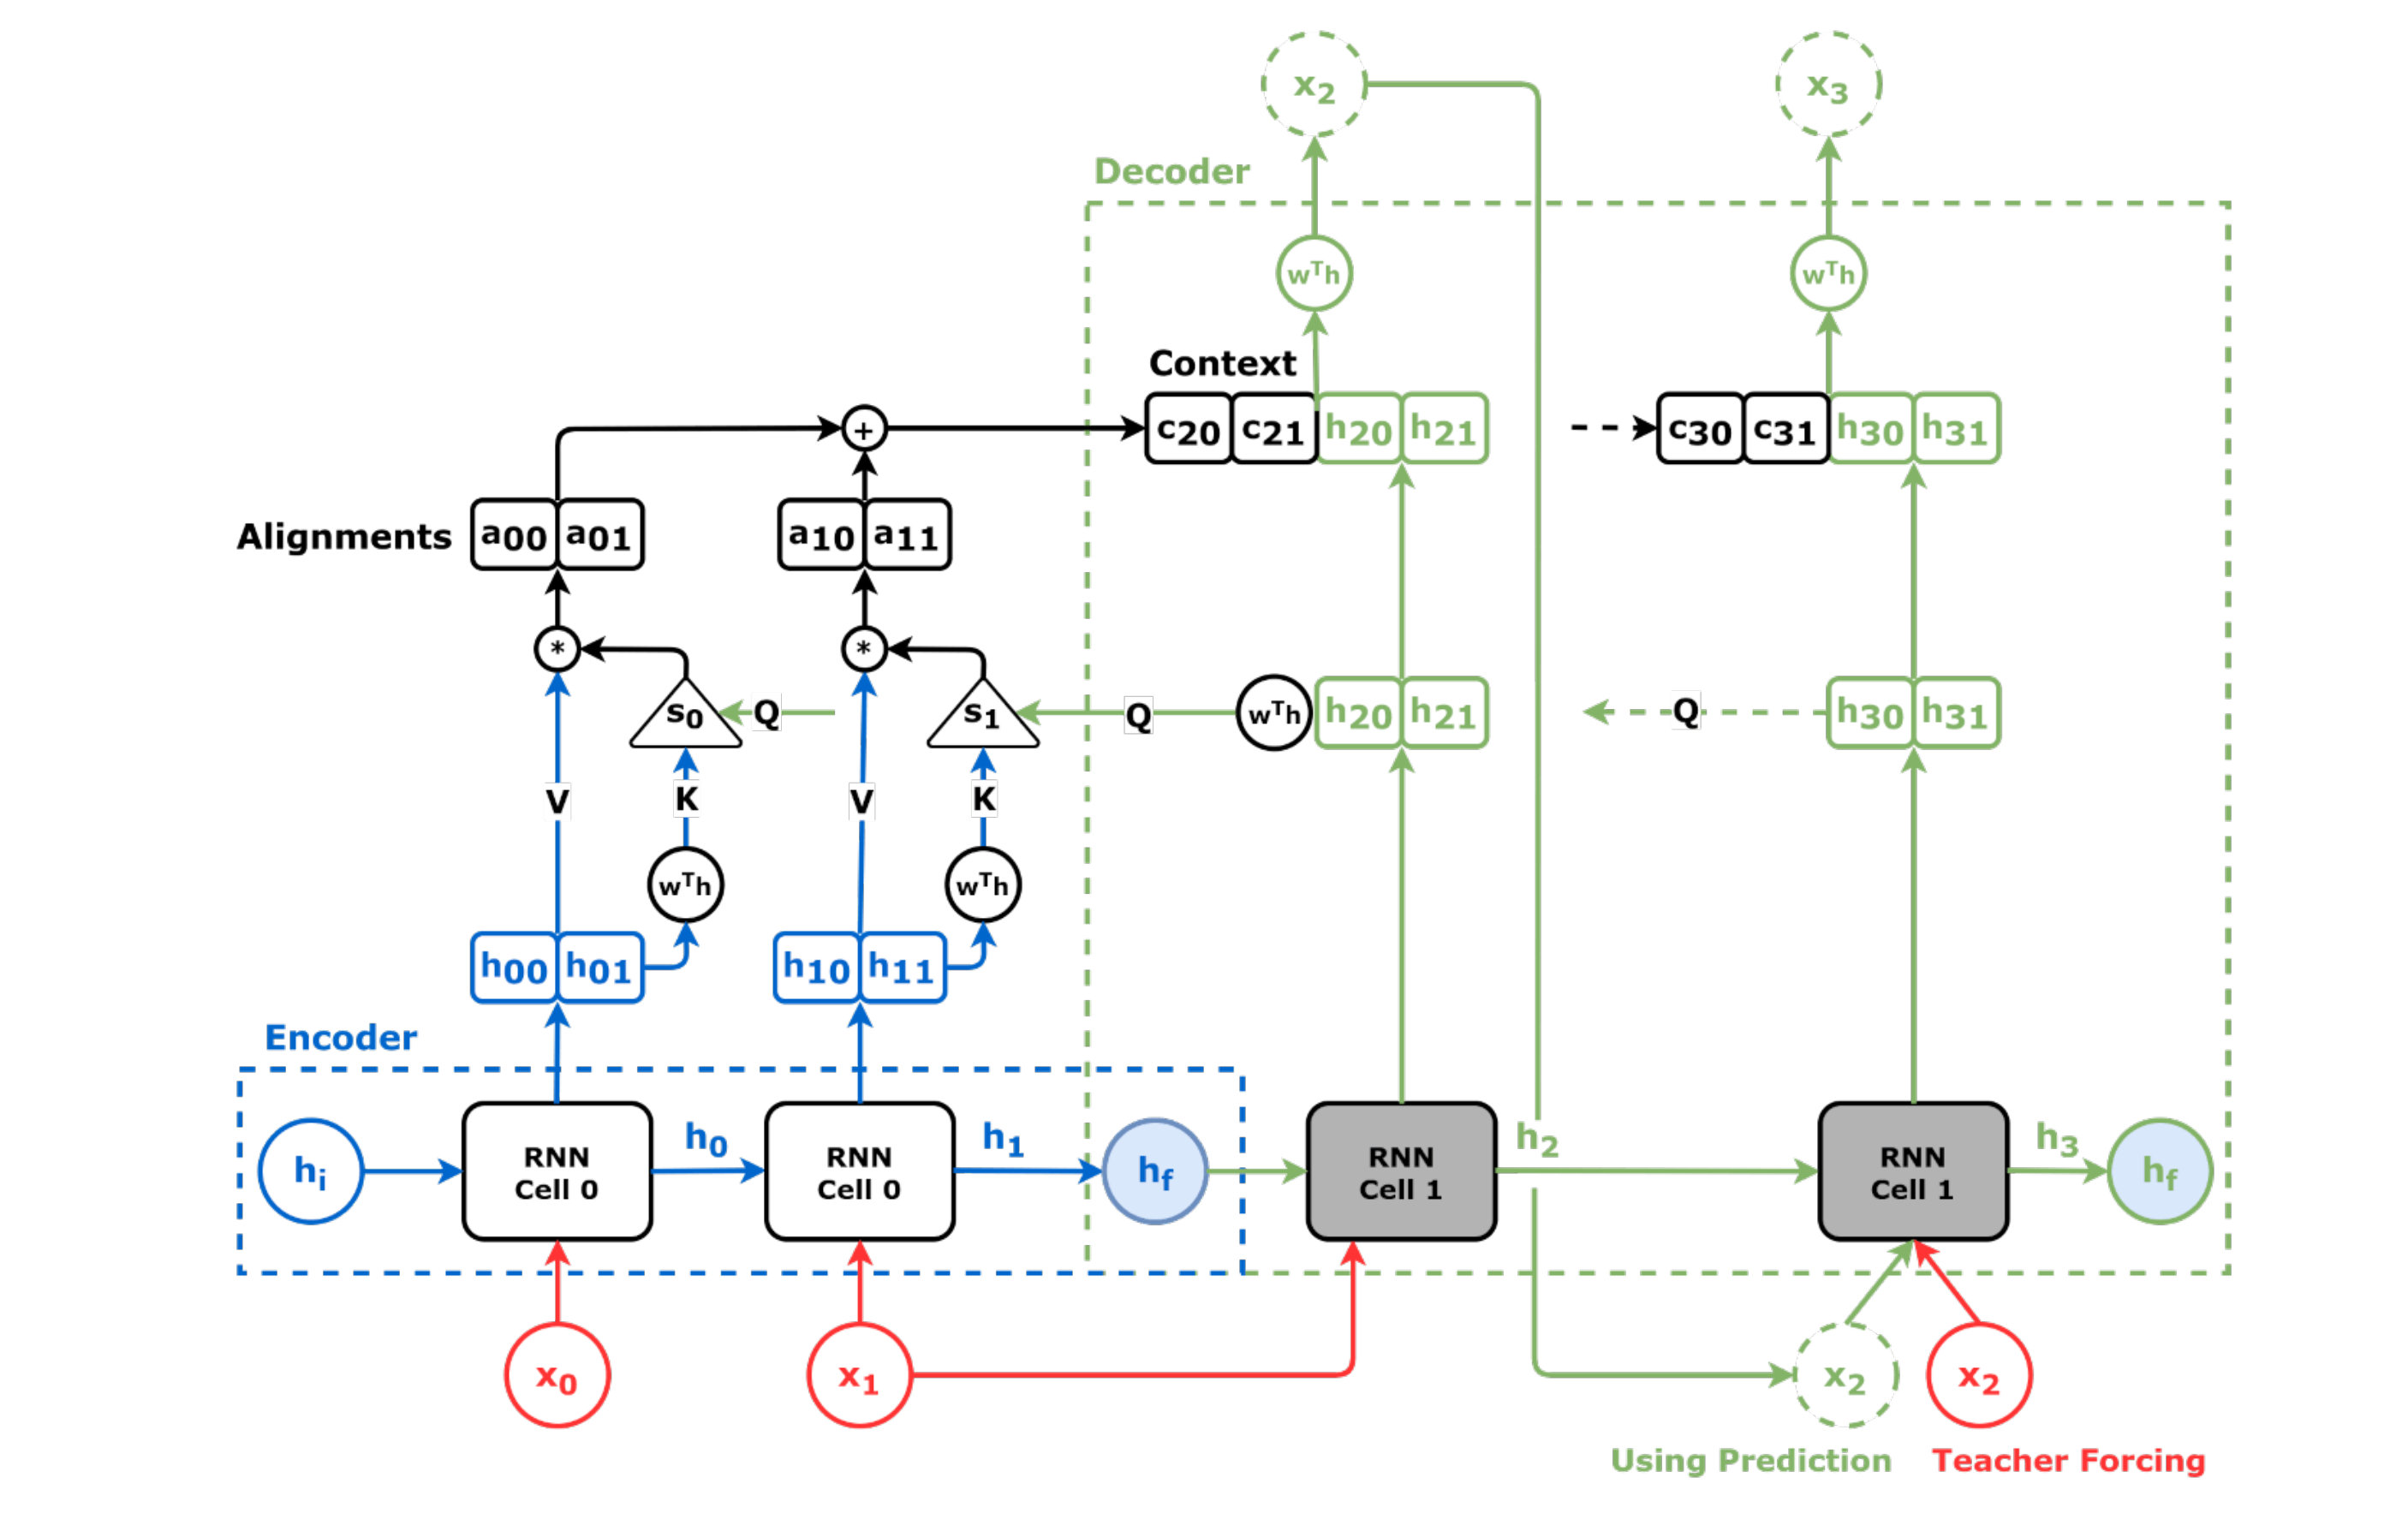

In [172]:
class EncoderDecoderAttn(EncoderDecoder):
    def __init__(self, encoder, decoder, input_len, target_len, 
                teacher_forcing_prob):
        super().__init__(encoder, decoder, input_len, target_len, teacher_forcing_prob)
        
        self.alphas=None
        
    def init_outputs(self, batch_size):
        device=next(self.parameters()).device
        #N, L(target), F
        self.outputs=torch.zeros(batch_size, 
                                self.target_len, 
                                self.encoder.n_features).to(device)
        self.alphas=torch.zeros(batch_size, 
                              self.target_len,
                              self.input_len).to(device)
    def store_output(self, i, out):
        #stores the output
        self.outputs[:, i:i+1, :] = out
        self.alphas[:, i:i+1,:]=self.decoder.attn.alphas
        

In [173]:
torch.manual_seed(17)
encoder = Encoder(n_features=2, hidden_dim=2)
decoder_attn = DecoderAttn(n_features=2, hidden_dim=2)
model = EncoderDecoderAttn(encoder, decoder_attn,
input_len=2, target_len=2,
teacher_forcing_prob=0.5)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [174]:
sbs_seq_attn = StepByStep(model, loss, optimizer)
sbs_seq_attn.set_loaders(train_loader, test_loader)
sbs_seq_attn.train(100)

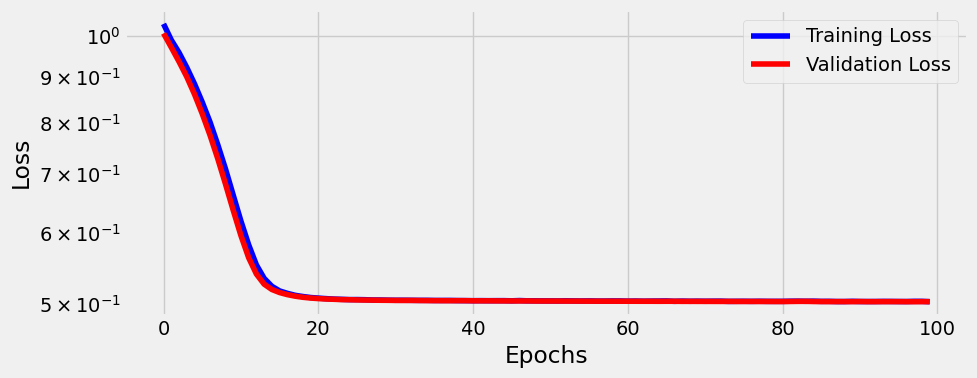

In [175]:
fig = sbs_seq_attn.plot_losses()
fig

## Multi-Headed Attention

In [176]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, 
                input_dim=None, proj_values=True):
        super().__init__()
        self.linear_out=nn.Linear(n_heads*d_model, d_model)
        self.attn_heads=nn.ModuleList(
            [Attention(d_model, 
                      input_dim=input_dim,
                      proj_values=proj_values) for _ in range(n_heads)])
        
    def init_keys(self, key):
        for attn in self.attn_heads:
            attn.init_keys(key)
            
    @property#not totally sure about this
    def alphas(self):
        #shape: n_heads, N, 1, L(source)
        return torch.stack(
        [attn.alphas for attn in self.attn_heads], dim=0
        )
    def output_function(self, context):
        #N, 1, n_heads*D
        concatenated=torch.cat(context, axis=-1)
        #linear transf to go back to original dimension
        out=self.linear_out(concatenated) #N,1,D
        return out
    
    def forward(self, query, mask=None):
        contexts = [attn(query, mask=mask) for attn in self.attn_heads]
        out = self.output_function(contexts)
        return out

## Self-Attention

What about replacing the recurrent layer with an attention mechanism?


#### Encoder
The next figure depicts an encoder using self-attention: the source works as "keys", "values" and "queries" as well. 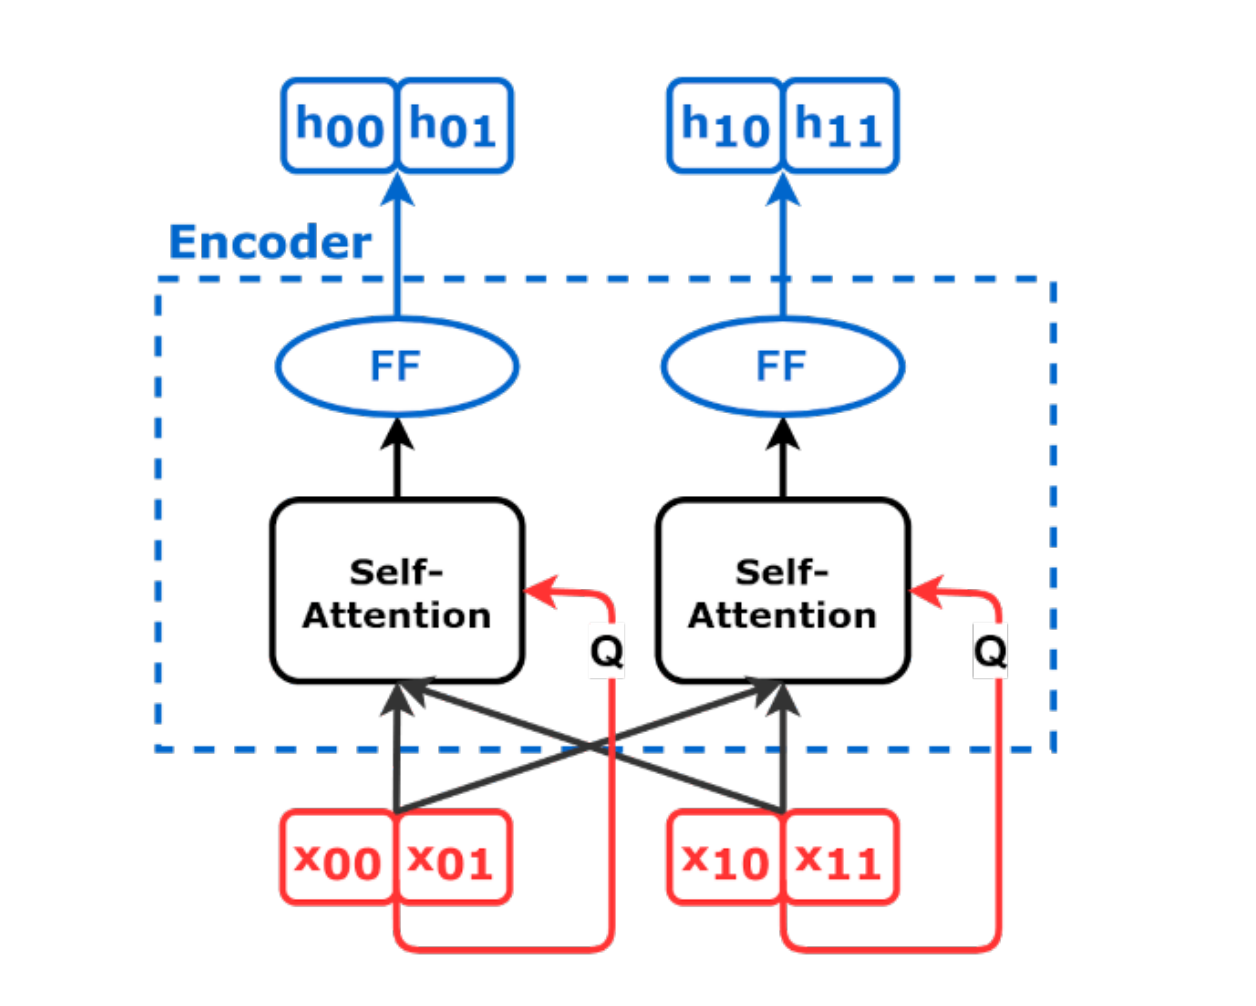

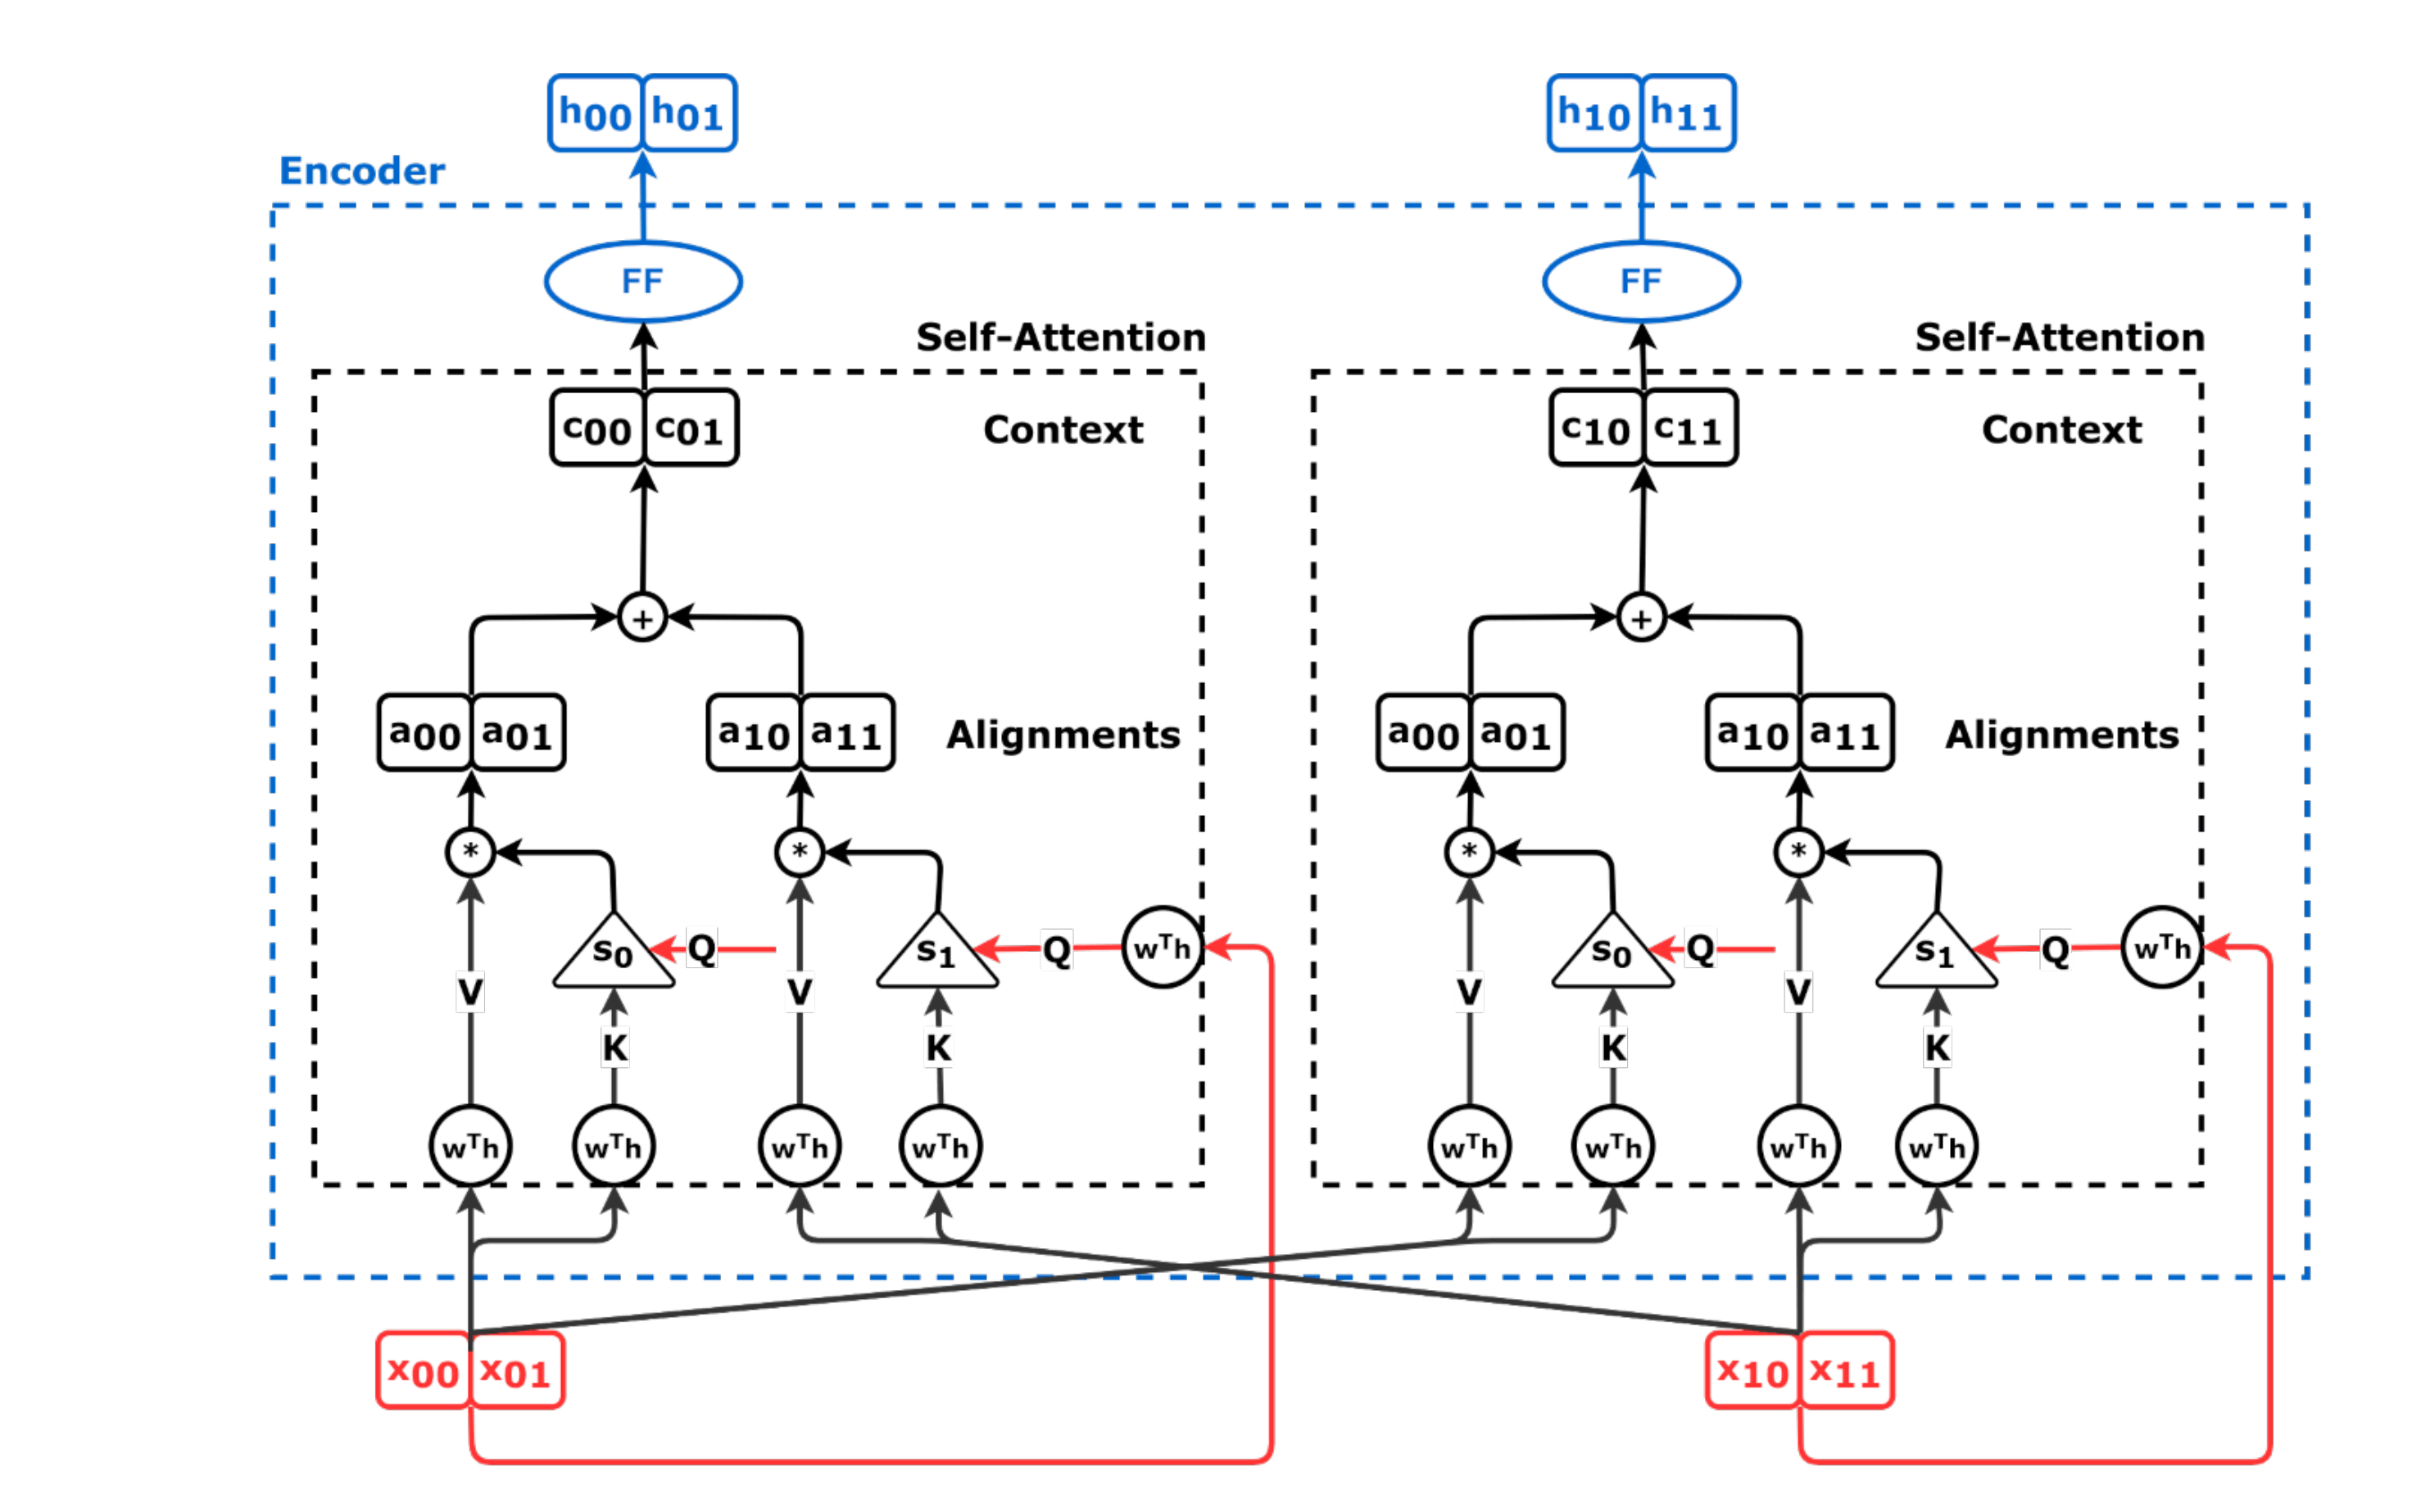

In [177]:
class EncoderSelfAttn(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None):
        super().__init__()
        self.n_heads=n_heads
        self.d_models=d_model
        self.ff_units=ff_units
        self.n_features=n_features
        self.self_attn_heads=MultiHeadAttention(n_heads,d_model,input_dim=n_features)
        self.ffn=nn.Sequential(
        nn.Linear(d_model, ff_units),
        nn.ReLU(),
        nn.Linear(ff_units, d_model),
        )
        
    def forward(self, query, mask=None):
        self.self_attn_heads.init_keys(query)
        att=self.self_attn_heads(query, mask)
        out=self.ffn(att)
        return out

In [178]:
torch.manual_seed(11)
encself=EncoderSelfAttn(n_heads=3, d_model=2, ff_units=10, n_features=2)

query=source_seq
encoder_states=encself(query)
encoder_states

tensor([[[-0.0498,  0.2193],
         [-0.0642,  0.2258]]], grad_fn=<AddBackward0>)

### Cross-Attention


In [179]:
class DecoderSelfAttn(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None):
        super().__init__()
        self.n_heads=n_heads
        self.d_model=d_model
        self.ff_units=ff_units
        self.n_features= d_model if n_features is None else n_features
        self.self_attn_heads=MultiHeadAttention(n_heads, d_model, input_dim=self.n_features)
        self.cross_attn_heads=MultiHeadAttention(n_heads, d_model)
        self.fnn=nn.Sequential(
        nn.Linear(d_model, ff_units),
        nn.ReLU(),
        nn.Linear(ff_units, self.n_features)
        )
        
    def init_keys(self, states):
        self.cross_attn_heads.init_keys(states)
    
    def forward(self, query, source_mask=None, target_mask=None):
        self.self_attn_heads.init_keys(query)
        att1=self.self_attn_heads(query, target_mask)
        att2=self.cross_attn_heads(att1, source_mask)
        out=self.fnn(att2)
        return out

In [180]:
def subsequent_mask(size):
    attn_shape=(1,size, size)
    subsequent_mask=(1 -torch.triu(torch.ones(attn_shape), diagonal=1)).bool()
    return subsequent_mask

In [181]:
subsequent_mask(2)

tensor([[[ True, False],
         [ True,  True]]])

In [182]:
shifted_seq=torch.cat([source_seq[:,-1:],
                      target_seq[:,:-1]], dim=1)

In [183]:
torch.manual_seed(13)
decself=DecoderSelfAttn(n_heads=3, d_model=2, ff_units=10, n_features=2)
decself.init_keys(encoder_states)
query=shifted_seq
out=decself(query, target_mask=subsequent_mask(2))

In [184]:
decself.self_attn_heads.alphas
out

tensor([[[0.4132, 0.3728],
         [0.4132, 0.3728]]], grad_fn=<AddBackward0>)

### Target mask (Evaluation/Prediction)

the only difference between training and evaluation, concerning the target mask, is that it will be using larger mas as it goes. The very first mask is trivial

In [185]:
inputs=source_seq[:,-1:,:]
trg_masks=subsequent_mask(1)
out=decself(inputs, trg_masks)
out

tensor([[[0.4132, 0.3728]]], grad_fn=<AddBackward0>)

Then that output will be used  directly as the next input

In [186]:
inputs=torch.cat([inputs, out[:,-1:,:]], dim=-2)
inputs

tensor([[[-1.0000,  1.0000],
         [ 0.4132,  0.3728]]], grad_fn=<CatBackward>)

In [187]:
trg_mask=subsequent_mask(2)
out=decself(inputs, trg_masks)
out

tensor([[[0.4132, 0.3728],
         [0.4132, 0.3728]]], grad_fn=<AddBackward0>)

In [188]:
inputs=torch.cat([inputs, out[:,-1:,:]], dim=-2)
inputs

tensor([[[-1.0000,  1.0000],
         [ 0.4132,  0.3728],
         [ 0.4132,  0.3728]]], grad_fn=<CatBackward>)

In [189]:
#but the prediction is just two datapoints, and the firstones were from the source sequence
inputs[:,1:]

tensor([[[0.4132, 0.3728],
         [0.4132, 0.3728]]], grad_fn=<SliceBackward>)

### Encoder + Decoder + Self-Attention 
stupid decoder

In [193]:
class EncoderDecoderSelfAttn(nn.Module):
    def __init__(self, encoder, decoder, input_len, target_len):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.input_len = input_len
        self.target_len = target_len
        self.trg_masks = self.subsequent_mask(self.target_len)
        
    @staticmethod
    def subsequent_mask(size):
        attn_shape = (1, size, size)
        subsequent_mask = (1 - torch.triu(torch.ones(attn_shape), diagonal=1))
        return subsequent_mask
                
    def encode(self, source_seq, source_mask):
        # Encodes the source sequence and uses the result
        # to initialize the decoder
        encoder_states = self.encoder(source_seq, source_mask)
        self.decoder.init_keys(encoder_states)
        
    def decode(self, shifted_target_seq, source_mask=None, target_mask=None):
        # Decodes/generates a sequence using the shifted (masked)
        # target sequence - used in TRAIN mode
        outputs = self.decoder(shifted_target_seq, 
                               source_mask=source_mask,
                               target_mask=target_mask)
        return outputs
    
    def predict(self, source_seq, source_mask):
        # Decodes/generates a sequence using one input
        # at a time - used in EVAL mode
        inputs = source_seq[:, -1:]
        for i in range(self.target_len):
            out = self.decode(inputs, source_mask, self.trg_masks[:, :i+1, :i+1])
            out = torch.cat([inputs, out[:, -1:, :]], dim=-2)
            inputs = out.detach()
        outputs = inputs[:, 1:, :]
        return outputs
                
    def forward(self, X, source_mask=None):
        # Sends the mask to the same device as the inputs
        self.trg_masks = self.trg_masks.type_as(X).bool()
        # Slices the input to get source sequence
        source_seq = X[:, :self.input_len, :]
        # Encodes source sequence AND initializes decoder
        self.encode(source_seq, source_mask)
        if self.training:
            # Slices the input to get the shifted target seq
            shifted_target_seq = X[:, self.input_len-1:-1, :]
            # Decodes using the mask to prevent cheating
            outputs = self.decode(shifted_target_seq, source_mask, self.trg_masks)
        else:
            # Decodes using its own predictions
            outputs = self.predict(source_seq, source_mask)
            
        return outputs
        
        
        
        
        

In [194]:
torch.manual_seed(23)
encself = EncoderSelfAttn(n_heads=3, d_model=2,
ff_units=10, n_features=2)
decself = DecoderSelfAttn(n_heads=3, d_model=2,
ff_units=10, n_features=2)
model = EncoderDecoderSelfAttn(encself, decself,
input_len=2, target_len=2)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [195]:
sbs_seq_selfattn = StepByStep(model, loss, optimizer)
sbs_seq_selfattn.set_loaders(train_loader, test_loader)
sbs_seq_selfattn.train(100)

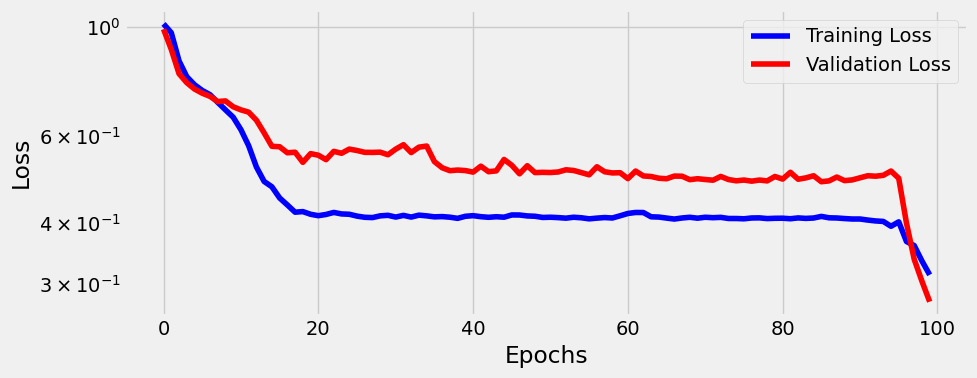

In [196]:
fig = sbs_seq_selfattn.plot_losses()
fig